In [1]:
import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np

# Import Videos

In [2]:
base_url = 'https://drive.google.com/uc?id='
book_video = base_url + '12-v0UI1OjLI3wxVP1VPfRBODtNplfIIj'
panda_video = base_url + '1te5I3FPBQrGtb1__DON8_cFLD1FDJ_yx'
book_cover_photo = base_url + '1aIbGkm6uCsZUfNhc1e9bk-hMMWZ1-HRf'
gdown.download(book_video)
gdown.download(panda_video)
gdown.download(book_cover_photo)

Downloading...
From: https://drive.google.com/uc?id=12-v0UI1OjLI3wxVP1VPfRBODtNplfIIj
To: /content/book.mov
100%|██████████| 28.5M/28.5M [00:00<00:00, 84.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1te5I3FPBQrGtb1__DON8_cFLD1FDJ_yx
To: /content/source.mov
100%|██████████| 6.29M/6.29M [00:00<00:00, 33.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aIbGkm6uCsZUfNhc1e9bk-hMMWZ1-HRf
To: /content/cover.jpg
100%|██████████| 117k/117k [00:00<00:00, 33.4MB/s]


'cover.jpg'

# General Functions

In [3]:
def display_image(image, title):
    plt.figure(figsize=(8, 8))
    if len(image.shape) == 3:  # Color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    else:  # Grayscale image
        plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Getting Correspondences

## Extract and Save Frame

In [4]:
def get_first_frame(video_path):
    '''
    Input: .mov file path
    Output: first frame of video as numpy array
    '''
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    return frame



book_frame = get_first_frame('/content/book.mov')
source_frame = get_first_frame('/content/source.mov')
cv2.imwrite('book_frame.jpg', book_frame) # save first frame as jpg
cv2.imwrite('source_frame.jpg', source_frame) # save first frame as jpg


True

## Get SIFT Keypoints

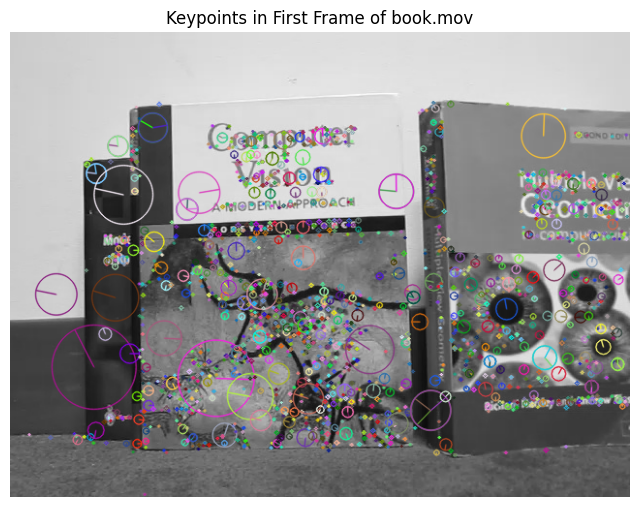

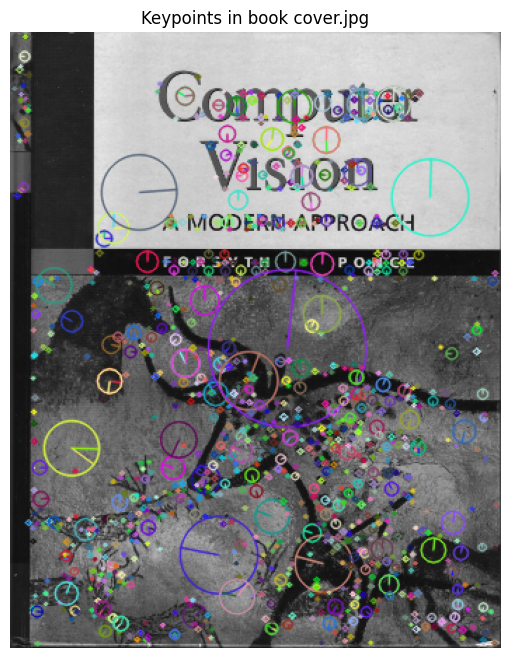

In [5]:
def extract_sift_keypoints(image, visualize=False, window_title="Keypoints"):
    """
    Extract SIFT keypoints and descriptors from an image.

    Parameters:
        image (numpy.ndarray): Input image.
        visualize (bool): Whether to display the image with keypoints.
        window_title (str): Title for the display window (if visualize=True).

    Returns:
        keypoints (list): List of detected keypoints.
        descriptors (numpy.ndarray): SIFT descriptors.
        image_with_keypoints (numpy.ndarray): Image with drawn keypoints (only if visualize=True).
    """
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    if visualize:
        # Draw keypoints on the image
        image_with_keypoints = cv2.drawKeypoints(
            gray_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        # Display the image with keypoints
        display_image(image_with_keypoints, window_title)
        return keypoints, descriptors

    return keypoints, descriptors

# Example Usage
book_frame = cv2.imread('/content/book_frame.jpg')
book_cover = cv2.imread('/content/cover.jpg')

keypoints_frame, descriptors_frame = extract_sift_keypoints(
    book_frame, visualize=True, window_title="Keypoints in First Frame of book.mov"
)

keypoints_book, descriptors_book = extract_sift_keypoints(
    book_cover, visualize=True, window_title="Keypoints in book cover.jpg"
)

## Match Keypoints

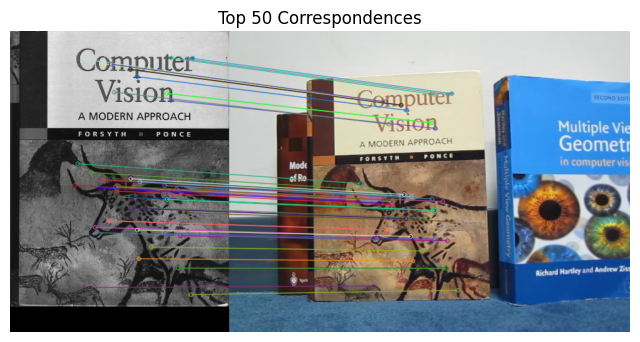

In [19]:
def match_keypoints(descriptors1, descriptors2, keypoints1, keypoints2,
                    image1, image2, ratio_thresh=0.3, top_n=50, visualize=False, window_title="Keypoint Matches"):
    """
    Match SIFT keypoints using a Brute Force Matcher with ratio test.

    Parameters:
        descriptors1 (numpy.ndarray): Descriptors of the first image.
        descriptors2 (numpy.ndarray): Descriptors of the second image.
        keypoints1 (list): Keypoints of the first image.
        keypoints2 (list): Keypoints of the second image.
        image1 (numpy.ndarray): The first image.
        image2 (numpy.ndarray): The second image.
        ratio_thresh (float): Ratio threshold for the ratio test.
        top_n (int): Number of top matches to retain for visualization.
        visualize (bool): Whether to display the matches.
        window_title (str): Title for the display window (if visualize=True).

    Returns:
        good_matches (list): List of good matches after the ratio test.
        matched_image (numpy.ndarray): Image with visualized matches (only if visualize=True).
    """
    # Initialize Brute Force Matcher
    bf = cv2.BFMatcher()

    # Perform KNN matching with k=2
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < ratio_thresh * n.distance]

    # Sort matches based on distance (best matches first)
    good_matches = sorted(good_matches, key=lambda x: x.distance)

    # Choose top N correspondences
    top_matches = good_matches[:top_n]

    if visualize:
        # Draw matches
        matched_image = cv2.drawMatches(
            image1, keypoints1,
            image2, keypoints2,
            top_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        # Display the matched image
        display_image(matched_image, window_title)
        return top_matches

    return top_matches

# Example Usage
ratio_thresh = 0.3
top_n = 50

top_matches = match_keypoints(
    descriptors_book, descriptors_frame,
    keypoints_book, keypoints_frame,
    book_cover, book_frame,
    ratio_thresh=ratio_thresh,
    top_n=top_n,
    visualize=True,
    window_title="Top 50 Correspondences"
)


# Computing Homography Matrix


In [7]:
def compute_homography(correspondences):
    """
    Computes the homography matrix from point correspondences.

    Parameters:
        correspondences (list of tuples): A list of at least 4 pairs of points.
                                          Each pair is ((x, y), (x', y')).

    Returns:
        H (numpy.ndarray): A 3x3 homography matrix.
    """
    # Construct the A matrix
    A = []
    for (x, y), (x_prime, y_prime) in correspondences:
        A.append([x, y, 1, 0, 0, 0, -x_prime * x, -x_prime * y, -x_prime])
        A.append([0, 0, 0, x, y, 1, -y_prime * x, -y_prime * y, -y_prime])
    A = np.array(A)

    # Perform SVD
    U, S, Vt = np.linalg.svd(A)

    # The last row of Vt (or last column of V) is the solution
    H = Vt[-1].reshape((3, 3))

    # Normalize H so that H[2, 2] = 1
    H = H / H[2, 2]

    return H

In [8]:
src_points = []
dst_points = []

for point_match in top_matches:
    # Retrieve corresponding keypoints
    query_pt = keypoints_book[point_match.queryIdx].pt
    train_pt = keypoints_frame[point_match.trainIdx].pt
    # Add to point lists
    src_points.append(query_pt)
    dst_points.append(train_pt)

#built-in homography
#Convert to NumPy arrays (required for cv2.findHomography)
src_points_np = np.float32(src_points).reshape(-1, 1, 2)
dst_points_np = np.float32(dst_points).reshape(-1, 1, 2)

H, mask = cv2.findHomography(src_points_np, dst_points_np, cv2.RANSAC, 5.0)
print("CV2 Homography Matrix:\n", H)

#using our implementation for computing homography matrix
correspondences = list(zip(src_points, dst_points))
#print("Correspondences:",correspondences)

H = compute_homography(correspondences)
print("Our Homography Matrix:\n", H)

CV2 Homography Matrix:
 [[ 7.82106480e-01  4.32109155e-03  1.18709370e+02]
 [-4.68431833e-02  7.82759064e-01  7.68574468e+01]
 [-7.35039230e-05 -7.18398553e-05  1.00000000e+00]]
Our Homography Matrix:
 [[ 7.81155822e-01  4.05360638e-03  1.18806224e+02]
 [-4.73962618e-02  7.82106679e-01  7.69756814e+01]
 [-7.52106415e-05 -7.26393981e-05  1.00000000e+00]]


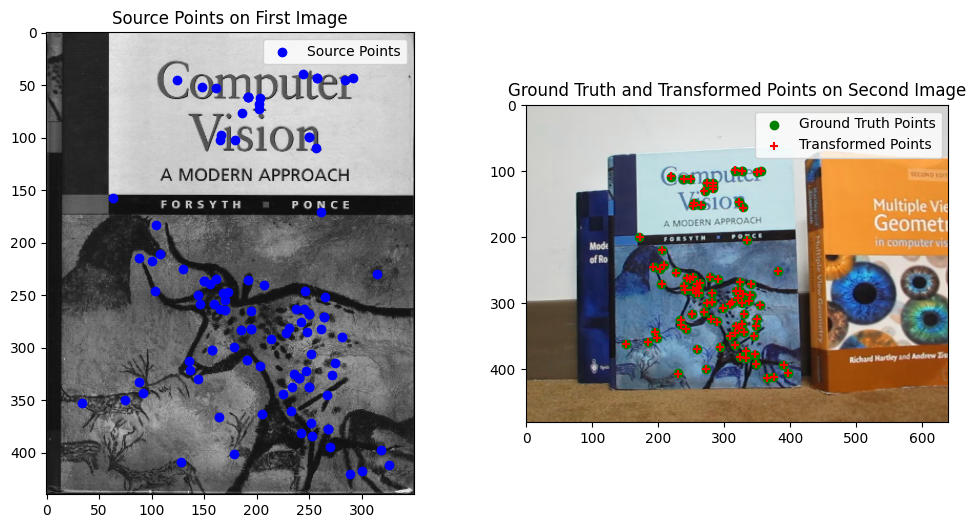

In [9]:
def verify_homography_mapping(H, src_points, dst_points, image_src, image_dst):
    """
    Verifies the computed homography by mapping points from one image to the other
    and displaying them.

    Parameters:
        H (numpy.ndarray): The computed 3x3 homography matrix.
        src_points (numpy.ndarray): Source points (clicked points) in the first image (n, 1, 2).
        dst_points (numpy.ndarray): Corresponding points in the second image (n, 1, 2).
        image_src (numpy.ndarray): First image.
        image_dst (numpy.ndarray): Second image.
    """
    # Convert source points to homogeneous coordinates
    src_points = np.float32(src_points)
    dst_points = np.float32(dst_points)
    src_points_homogeneous = cv2.convertPointsToHomogeneous(src_points).reshape(-1, 3).T  # Shape: (3, n)

    # Transform points using the homography matrix
    transformed_points_homogeneous = np.dot(H, src_points_homogeneous)  # Shape: (3, n)

    # Normalize transformed points to Cartesian coordinates
    transformed_points_homogeneous /= transformed_points_homogeneous[2]  # Divide by w
    transformed_points = transformed_points_homogeneous[:2].T  # Back to shape (n, 2)

    # Convert dst_points to Cartesian for visualization
    dst_points_cartesian = dst_points.reshape(-1, 2)

    # Visualization
    # Plot the source points on the source image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_src, cmap='gray')
    plt.scatter(src_points[:,0], src_points[:,1], color='blue', label='Source Points')
    plt.title("Source Points on First Image")
    plt.legend()

    # Plot the transformed points and ground truth points on the second image
    plt.subplot(1, 2, 2)
    plt.imshow(image_dst, cmap='gray')
    plt.scatter(dst_points_cartesian[:, 0], dst_points_cartesian[:, 1], color='green', label='Ground Truth Points')
    plt.scatter(transformed_points[:, 0], transformed_points[:, 1], color='red', label='Transformed Points', marker='+')
    plt.title("Ground Truth and Transformed Points on Second Image")
    plt.legend()

    plt.show()

verify_homography_mapping(H, src_points, dst_points, book_cover, book_frame)

# Calculating Book Coordinates


[[  0.   0.   1.]
 [350.   0.   1.]
 [  0. 440.   1.]
 [350. 440.   1.]]
Transformed corner points in the second image:
 [[118.80622405  76.97568136]
 [402.8143355   62.01957597]
 [124.57127513 435.00599243]
 [418.37963043 429.55029294]]


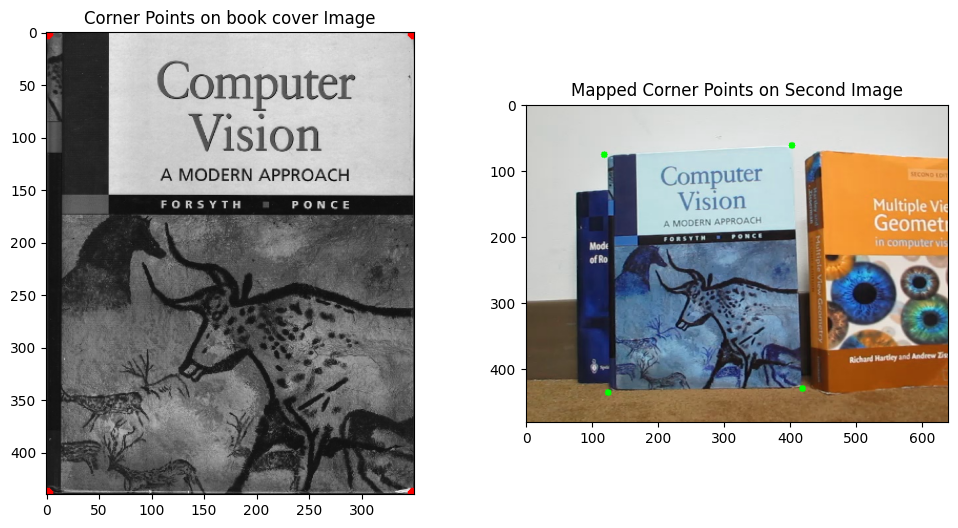

In [10]:
#get corner points of book cover.
corner_points = np.float32([[0, 0], [book_cover.shape[1], 0], [0, book_cover.shape[0]], [book_cover.shape[1], book_cover.shape[0]]])

# Convert to homogeneous coordinates (adding 1 to each point)
bookcover_corners_homogeneous = np.hstack([corner_points, np.ones((corner_points.shape[0], 1))])
print(bookcover_corners_homogeneous)
corners_second_image_homogeneous = np.dot(H, bookcover_corners_homogeneous.T).T  # Shape (4, 3)

# Normalize the points by dividing by the third coordinate (w)
corners_second_image = corners_second_image_homogeneous[:, :2] / corners_second_image_homogeneous[:, 2:3]

# Print the transformed corner points
print("Transformed corner points in the second image:\n", corners_second_image)

# Display the result on the second image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(book_cover, cmap='gray')
book_cover_with_corners = book_cover.copy()  # Copy to avoid modifying the original
for point in corner_points:
    cv2.circle(book_cover_with_corners, tuple(point.astype(int)), 7, (255, 0, 0), -1)  # Green circles

# Plot the second image with the mapped corners
plt.imshow(book_cover_with_corners, cmap='gray')
plt.title("Corner Points on book cover Image")


plt.subplot(1, 2, 2)
book_frame_with_corners = book_frame.copy()  # Copy to avoid modifying the original
for point in corners_second_image:
    cv2.circle(book_frame_with_corners, tuple(point.astype(int)), 5, (0, 255, 0), -1)  # Green circles

# Plot the second image with the mapped corners
plt.imshow(book_frame_with_corners, cmap='gray')
plt.title("Mapped Corner Points on Second Image")
plt.show()


# Crop AR Video Frames

In [11]:
def crop_video(input_path, output_path, crop_x, crop_y, crop_width, crop_height):
    # Open the input video
    cap = cv2.VideoCapture(input_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MOV container with MP4 encoding

    # Open the VideoWriter
    out = cv2.VideoWriter(output_path, fourcc, fps, (crop_width, crop_height))

    # Process each frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Crop the frame
        cropped_frame = frame[crop_y:crop_y + crop_height, crop_x:crop_x + crop_width]

        # Write the cropped frame to the output
        out.write(cropped_frame)

    # Release resources
    cap.release()
    out.release()
    print(f"Video saved to {output_path}")




# Book aspect ratio
book_aspect_ratio = book_cover.shape[1] / book_cover.shape[0]

# First frame aspect ratio
frame_aspect_ratio = source_frame.shape[1] / source_frame.shape[0]

print(f"Book Shape: {book_cover.shape}, Book aspect ratio: {book_aspect_ratio}")
print(f"Frame Shape: {source_frame.shape}, Frame aspect ratio: {frame_aspect_ratio}")


# Scale Book shape to be similar to frame shape (while maintaining book aspect ratio)
black_bar_offset = 44 # Offset to remove top and bottom black bars in video frame
scale_factor = (source_frame.shape[0]- 2 * black_bar_offset) / book_cover.shape[0]
crop_height = int(book_cover.shape[0] * scale_factor)
crop_width = int(book_cover.shape[1] * scale_factor)
print(crop_height, crop_width)

# Get center frame top-left coordinates
top_left_row = black_bar_offset
top_left_col = int((source_frame.shape[1] - crop_width)/2)

# Parameters
input_video = "/content/source.mov"
output_video = "/content/cropped_source.mov"

# Call the function
crop_video(input_video, output_video, top_left_col, top_left_row, crop_width, crop_height)



Book Shape: (440, 350, 3), Book aspect ratio: 0.7954545454545454
Frame Shape: (360, 640, 3), Frame aspect ratio: 1.7777777777777777
272 216
Video saved to /content/cropped_source.mov


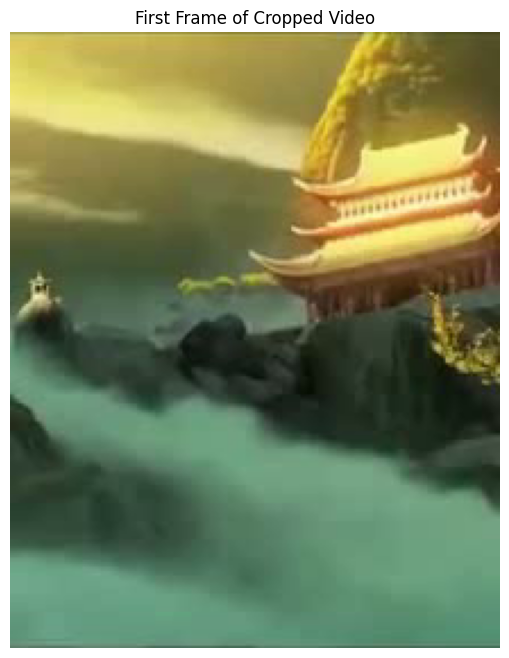

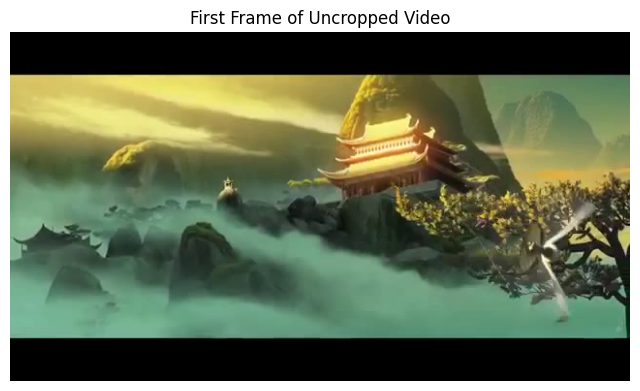

In [12]:
first_cropped_frame = get_first_frame('/content/cropped_source.mov')

display_image(first_cropped_frame, "First Frame of Cropped Video")


display_image(source_frame, "First Frame of Uncropped Video")

# Overlay the First Frame of the Two Videos

## Upscale the First Frame

In [13]:
def upscale_frame(frame, target_shape):
    """
    Upscale a video frame to match the book cover's shape.
    Both have the same aspect ratio.

    Parameters:
        frame (numpy.ndarray): The original video frame (H, W, C).
        target_shape (tuple): The target shape (H, W, C).

    Returns:
        numpy.ndarray: The upscaled frame.
    """
    target_height, target_width = target_shape[:2]
    # Resize the frame to the target shape
    upscaled_frame = cv2.resize(frame, (target_width, target_height), interpolation=cv2.INTER_CUBIC)
    return upscaled_frame



first_cropped_frame = get_first_frame('/content/cropped_source.mov')
print(f"Cropped Video Frame Shape {first_cropped_frame.shape}")
print(f"Book cover Shape {book_cover.shape}")
upscaled_frame = upscale_frame(first_cropped_frame, book_cover.shape)

Cropped Video Frame Shape (272, 216, 3)
Book cover Shape (440, 350, 3)


## Transform Upscaled Frame

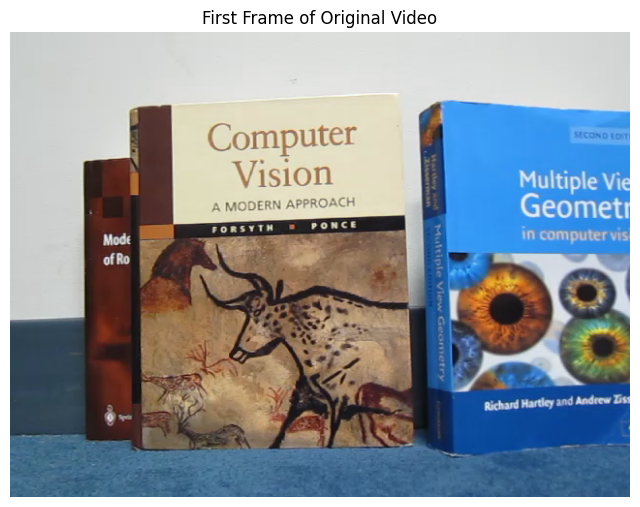

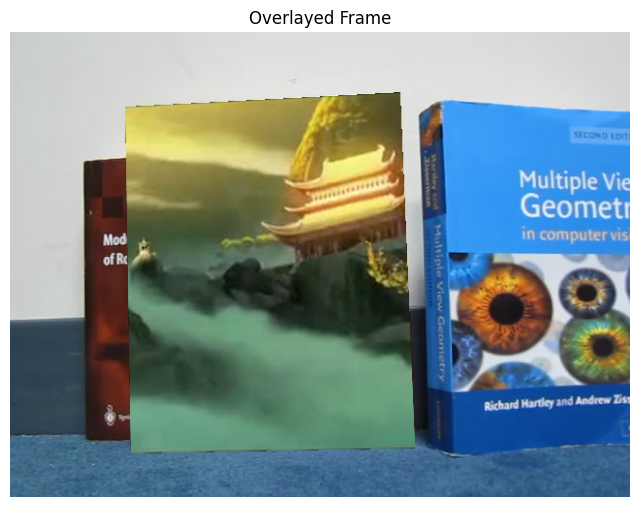

In [23]:
def apply_homography_and_overlay(upscaled_frame, original_frame, H):
    """
    Apply a homography transformation to the upscaled frame and overlay it onto the original frame.

    Parameters:
        upscaled_frame (numpy.ndarray): The upscaled frame to be transformed.
        original_frame (numpy.ndarray): The original video frame.
        H (numpy.ndarray): The 3x3 homography matrix.

    Returns:
        numpy.ndarray: The resulting frame with the overlay.
    """
    # Dimensions of the original frame
    h, w, _ = original_frame.shape

    # Apply the homography to the upscaled frame
    transformed_frame = cv2.warpPerspective(upscaled_frame, H, (w, h))

    # Create a binary mask for the transformed frame
    mask = cv2.warpPerspective(
        np.ones(upscaled_frame.shape[:2], dtype=np.uint8), H, (w, h)
    )

    # Normalize the mask to [0, 1] range for blending
    mask = mask.astype(bool)

    # Create the overlayed frame
    overlayed_frame = original_frame.copy()

    # Blend valid transformed pixels into the original frame
    overlayed_frame[mask] = transformed_frame[mask]

    return overlayed_frame




first_original_frame = get_first_frame('/content/book.mov')

display_image(first_original_frame, "First Frame of Original Video")

overlayed_frame = apply_homography_and_overlay(upscaled_frame, first_original_frame, H)

display_image(overlayed_frame, "Overlayed Frame")

# Overlay the entire video

In [42]:
def process_video(book_video_path, source_video_path, output_video_path):
    """
    Processes two videos frame by frame, computes the homography, overlays the upscaled source frame onto the book frame,
    and creates a combined output video.

    Parameters:
        book_video_path (str): Path to the book video (e.g., 'book.mov').
        source_video_path (str): Path to the cropped source video (e.g., 'cropped_source.mov').
        output_video_path (str): Path to save the output video (e.g., 'output.mov').
    """
    # Open both videos
    book_cap = cv2.VideoCapture(book_video_path)
    source_cap = cv2.VideoCapture(source_video_path)

    # Get video properties (assume both videos have the same properties)
    fps = int(book_cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(book_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(book_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(book_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize the VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    print(f"Processing video: {frame_width}x{frame_height}, {fps} FPS, {frame_count} frames")

    # Process each frame
    frame_idx = 0
    keypoints_book_img, descriptors_book_img = extract_sift_keypoints(book_cover) # Keypoints for Book cover image
    prev_H = None
    while True:
        ret_book, book_frame = book_cap.read()
        ret_source, source_frame = source_cap.read()

        if not ret_book or not ret_source:
            break  # End of video

        # Step 1: Extract SIFT keypoints and matches
        keypoints_book_video, descriptors_book_video = extract_sift_keypoints(book_frame)


        top_matches = match_keypoints(
            descriptors_book_video, descriptors_book_img,
            keypoints_book_video, keypoints_book_img,
            book_frame, book_cover,
            ratio_thresh=0.3,
            top_n=50,
            visualize=False
        )

        # Get point correspondences for homography
        correspondences = []
        for top_match in top_matches:
            book_video_pt = keypoints_book_video[top_match.queryIdx].pt  # Point in book frame
            book_img_pt = keypoints_book_img[top_match.trainIdx].pt  # Point in book cover image
            correspondences.append((book_img_pt, book_video_pt))



        # Step 2: Compute the homography matrix
        H = compute_homography(correspondences)
        if (prev_H is not None) and (np.square(H-prev_H).sum() > 1000):
          H = prev_H
        prev_H = H

        # Step 3: Upscale the source frame
        upscaled_source_frame = upscale_frame(source_frame, book_cover.shape)

        # Step 4: Apply homography and overlay
        overlayed_frame = apply_homography_and_overlay(upscaled_source_frame, book_frame, H)

        # Step 5: Write the resulting frame to the output video
        out.write(overlayed_frame)

        frame_idx += 1
        if frame_idx % 50 == 0:
            print(f"Processed {frame_idx} frames")

    # Release resources
    book_cap.release()
    source_cap.release()
    out.release()
    print(f"Output video saved to {output_video_path}")

# Example usage
book_video_path = '/content/book.mov'
source_video_path = '/content/cropped_source.mov'
output_video_path = '/content/output_video.mov'

process_video(book_video_path, source_video_path, output_video_path)

Processing video: 640x480, 30 FPS, 641 frames
Processed 50 frames
Processed 100 frames
Processed 150 frames
Processed 200 frames
Processed 250 frames
Processed 300 frames
Processed 350 frames
Processed 400 frames
Processed 450 frames
Processed 500 frames
Output video saved to /content/output_video.mov
